In [1]:
import json
import pandas as pd 
import glob 
import os 
import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def read_json(filename):
    with open(filename, 'r') as file: 
        return json.load(file)

In [3]:
files = glob.glob('jsons/*')

In [4]:
def return_all_keys(adict, key_suff=''): 
    all_keys = []
    for key, value in adict.items():
        if isinstance(value, dict): 
            all_keys += return_all_keys(value, key_suff=f'{key}->')
        all_keys.append(key_suff + key)
    return all_keys


In [5]:
whole_data = []
for file in tqdm.tqdm(files):
    data = read_json(file)
    if 'code' in data and data['code'] == 400000:
        continue
    if 'list' in data: 
        rows = pd.json_normalize(data['list'])
        rows['lat'], rows['lng'] = os.path.basename(file).replace('.json', '').split('_')
        whole_data.append(rows)
whole_data = pd.concat(whole_data)

100%|███████████████████████████████████████████████████████████████████████████████| 393/393 [00:02<00:00, 150.65it/s]


In [6]:
whole_data = whole_data.drop(['weather', 'wind.gust', 'main.feels_like', 'main.temp_min','main.temp_max'], axis=1)

In [7]:
whole_data.count()

dt               25670
main.temp        25670
main.pressure    25670
main.humidity    25670
wind.speed       25670
wind.deg         25670
clouds.all       25670
snow.1h           1407
lat              25670
lng              25670
rain.1h            938
dtype: int64

In [8]:
whole_data = whole_data.fillna(0)

In [9]:
whole_data = whole_data.rename({'dt': 'time_unix'}, axis=1)

In [10]:
whole_data['lat'] = whole_data['lat'].apply(float)
whole_data['lng'] = whole_data['lng'].apply(float)

In [11]:
air = pd.read_feather('air_data.feather')

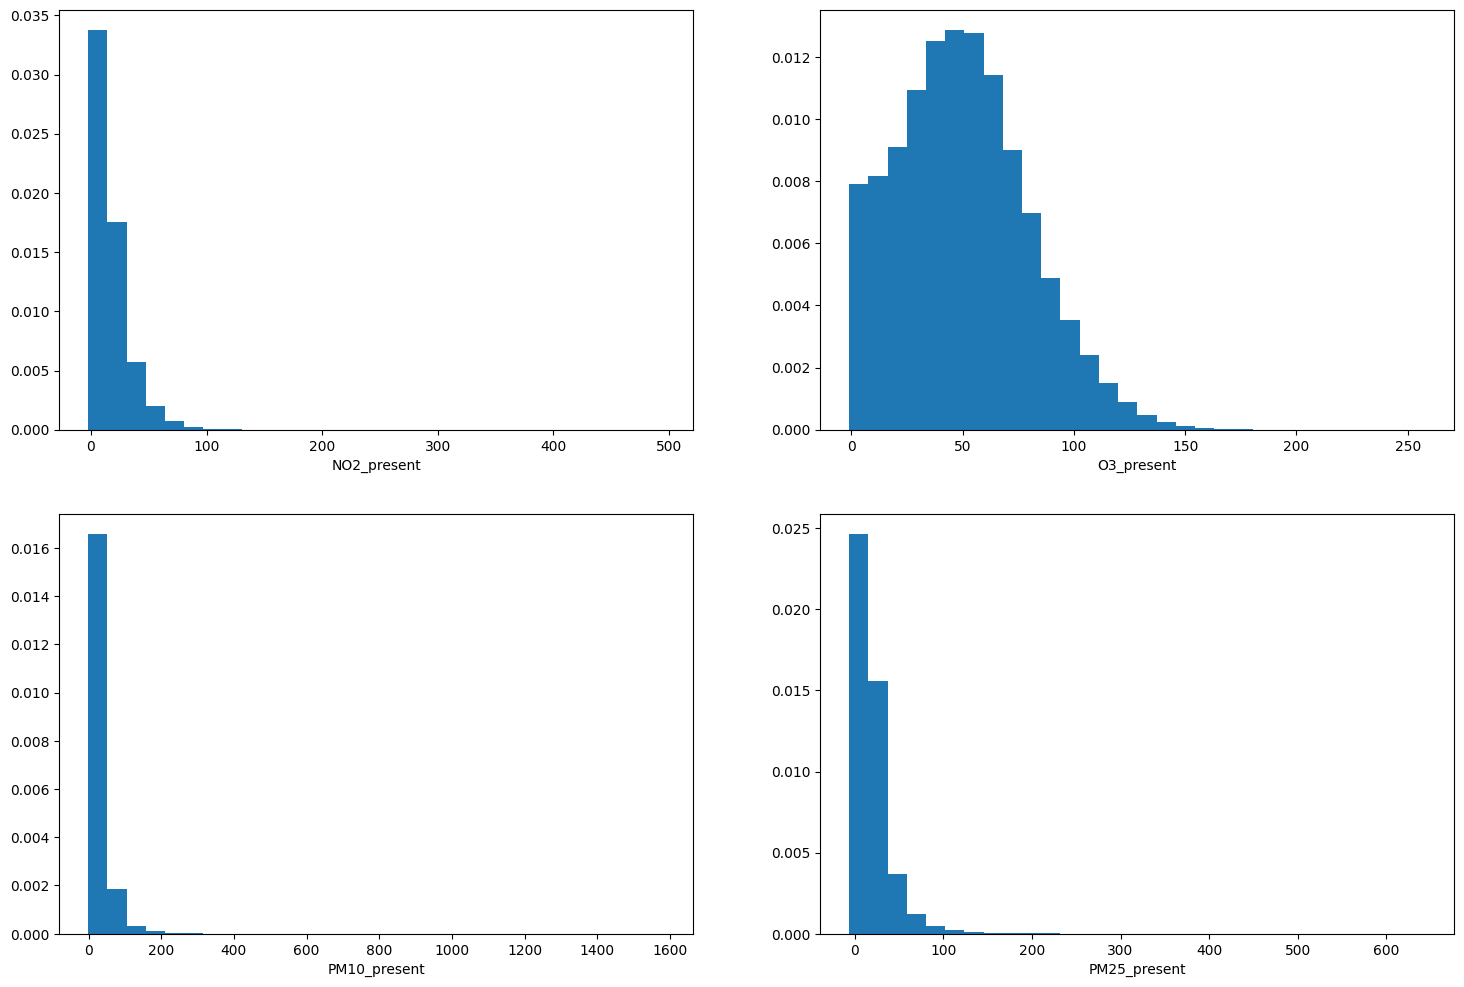

In [38]:
cols = ['NO2_present','O3_present','PM10_present','PM25_present']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9*2, 6*2))
axs = axs.flatten()
for i, col in enumerate(cols):
    axs[i].hist(air[col], bins=30, density=True)
    axs[i].set_xlabel(col)
plt.savefig('hist.png', dpi=1000)
    

In [13]:
data = air.merge(whole_data)

In [14]:
data['time'] = pd.to_datetime(data['time_unix'],unit='s')

In [15]:
data['month'] = data['time'].apply(lambda x: x.month)
data['hour'] = data['time'].apply(lambda x: x.hour)
data['weekday'] = data['time'].apply(lambda x: x.weekday())

In [18]:
data.columns

Index(['NO2_present', 'O3_present', 'PM10_present', 'PM25_present',
       'time_unix', 'NO2_future', 'O3_future', 'PM10_future', 'PM25_future',
       'time_unix_plus_1h', 'lat', 'lng', 'main.temp', 'main.pressure',
       'main.humidity', 'wind.speed', 'wind.deg', 'clouds.all', 'snow.1h',
       'rain.1h', 'time', 'month', 'hour', 'weekday'],
      dtype='object')

In [39]:
corrs = data.drop(['lat', 'lng', 'time_unix_plus_1h', 'time_unix'], axis=1)\
    .corr('spearman')
corrs[corrs.apply(abs) > 0.7]

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21224\2055262608.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = data.drop(['lat', 'lng', 'time_unix_plus_1h', 'time_unix'], axis=1)\


,NO2_present,O3_present,PM10_present,PM25_present,NO2_future,O3_future,PM10_future,PM25_future,main.temp,main.pressure,main.humidity,wind.speed,wind.deg,clouds.all,snow.1h,rain.1h,month,hour,weekday
NO2_present,1.000000,-0.719930,0.724020,0.714212,0.958485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O3_present,-0.719930,1.000000,NaN,NaN,-0.709479,0.968489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PM10_present,0.724020,NaN,1.000000,0.981235,0.719215,NaN,0.957732,0.945925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PM25_present,0.714212,NaN,0.981235,1.000000,0.706031,NaN,0.948553,0.963487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NO2_future,0.958485,-0.709479,0.719215,0.706031,1.000000,-0.722468,0.723862,0.713716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O3_future,NaN,0.968489,NaN,NaN,-0.722468,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PM10_future,NaN,NaN,0.957732,0.948553,0.723862,NaN,1.000000,0.981225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PM25_future,NaN,NaN,0.945925,0.963487,0.713716,NaN,0.981225,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
main.temp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
main.pressure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
corrs[['main.temp', 'wind.speed']].apply(lambda x: round(x,2))

,main.temp,wind.speed
NO2_present,-0.16,-0.35
O3_present,-0.20,0.25
PM10_present,-0.45,-0.40
PM25_present,-0.45,-0.42
NO2_future,-0.14,-0.32
O3_future,-0.23,0.22
PM10_future,-0.42,-0.38
PM25_future,-0.42,-0.40
main.temp,1.00,0.31
main.pressure,-0.19,-0.08


In [16]:
data = data.drop(['time', 'time_unix_plus_1h', 'lat', 'lng', 'time_unix'], axis=1)

In [17]:
data = data.rename({col: col.replace('.', '_') for col in data.columns}, axis=1)

In [48]:
particles = ['NO2', 'O3', 'PM25', 'PM10']

In [51]:
counts = []
for particle in particles: 
    n = len(data[(data[f'{particle}_future'] == data[f'{particle}_future']) & (data[f'{particle}_present'] == data[f'{particle}_present'])])
    counts.append((particle, n))
pd.DataFrame(counts, columns=['particle', 'n'])

,particle,n
0,NO2,18569
1,O3,13213
2,PM25,10164
3,PM10,20706


In [22]:
with open('medians.json', 'w') as file: 
    json.dump({col: data[col].median() for col in data.columns[8:]}, file)

In [23]:
data.to_csv('complete_data.csv', index=False)